# Introduction
 
**Playing with Deep Learning**

The dataset we have at our disposal includes "only" some thousands of tweets. Supposedly, one would think that, to apply Deep Learning techniques, a larger amount of data would be needed (or is it really?)

Well, this in not true, or at least, this is not anymore completely true thanks to **Transfer Learning**. If you are training a huge model from scratch, you need a lot of data and GPU time. Lucklily for us, these huge models are already pre-trained for many languages using large datasets (e.g. Wikipedia). In more detail, these models are called **Language Models (LM)** because they are, surprisingly, ... models of your language. LM are trained on a rather simple task: given a sequence of words in a sentence, predict the next one. A properly trained LM should then identify that given the sentence `The dog is`, `black` is more likely than `red` (there are no red dogs). By optimizing this task, what the LM are actually doing is learning the gramatical, lexical and semantical relationships of the language, thus grasping a deep understanding of its textual content. 

All we have to do is to adapt these LM to our particular domain. In layman words, the LM already speaks English and we need to teach them to talk *Twitterish*. Thousands of tweets are not enough to learn English, but they are definitely enough to learn the nuances of the dataset.

The objective now is to create a Classifier. Now, thanks to the LM, it's possible to feed said Classifier with a much more detailed and accurate representation of the input textual content. Therefore, it should be easier to the Classifier to better categorize the textual content.


Summing up, my strategy will be:

1.   Use a pre-trained English Language Model trained over a large dataset as starting point.
2.   Adapt this language model to our domain. To that end, I will retrain the model to learn the particular aspects of the dataset.
3. Create a Machine Learning Classifier on top of the dataset language model


**Side note: The initial model was trained, by the NLP Course Professor, on Google Colab to be able to use a GPU.For this reason, it is not included anything about the configuration of the GPU or the installation of the required libraries


## Fast AI


To facilitate the training of this deep learning approach, I will make use of the [fast.ai library](https://www.fast.ai/). In particular, the [`text`](https://docs.fast.ai/text.html) module of the fast.ai library contains all the necessary functions. Specifically:

- [`text.transform`](https://docs.fast.ai/text.transform.html#text.transform) contains all the scripts to preprocess the data, from raw text to token ids,
- [`text.data`](https://docs.fast.ai/text.data.html#text.data) contains the definition of [`TextDataBunch`](https://docs.fast.ai/text.data.html#TextDataBunch), which is the main class we need in NLP,
- [`text.learner`](https://docs.fast.ai/text.learner.html#text.learner) contains helper functions to quickly create a language model or an text classifier.



In [0]:
# I needed this to load data from my GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



## Training a classifier model


To create my model I am going to apply the following steps:

1. Fine-tuning an [AWD-LSTM](https://arxiv.org/abs/1708.02182) model to create a language model based on our data.
1. Building a classifier based on the learned language model

### Reading and viewing the data

First let's import everything we need for text.

In [0]:
from fastai.text import *


I will now read the dataset from the original CSV files


In [0]:
training_df = pd.read_csv('/content/drive/My Drive/nlp_disaster/data/train.csv', sep=',', index_col=0)
training_df = training_df.sample(frac=1).reset_index(drop=True)
training_df.head(20)

,keyword,location,text,target
0,nuclear%20reactor,NaN,Navy sidelines 3 newest subs http://t.co/gpVZV...,0
1,rescuers,Kuala Lumpur,VIDEO: 'We're picking up bodies from water': R...,1
2,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
3,destroyed,NaN,Emotionally I am destroyed,0
4,injured,"Paterson, New Jersey",Yelp Bolsters Health Care Reviews With Investi...,1
5,bleeding,dmv ?? fashion school @ KSU.,i hit my foot now my toe is bleeding ??,0
6,mudslide,"Edinburgh, Scotland",@Pete_r_Knox @Gemmasterful I think the mudslid...,0
7,avalanche,"Danville, VA",No snowflake in an avalanche ever feels respon...,0
8,siren,My subconscious,@stacedemon oh shit!,0
9,detonation,NaN,Ignition Knock (Detonation) Sensor-Senso Stand...,0


In [0]:
test_df = pd.read_csv('/content/drive/My Drive/nlp_disaster/data/test.csv', sep=',', index_col=0)
test_df.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Getting your data ready for modeling

fast.ai provides some helpful loaders to format the input data to the format required by the Deep Learning Model.

The main structure we need to create is the [`DataBunch`](https://docs.fast.ai/basic_data.html#DataBunch) that creates the training and validation sets by grabbing the textual data from the required columns.

Here we'll use the method <code>from_df</code> of the [`TextList`](https://docs.fast.ai/text.data.html#TextList) to get the data ready for the fine-tuning of the language model and to get the data ready for the classification step.

In [0]:
# Language model data

cols=['text']
data_lm = (TextList.from_df(training_df, cols=cols)
                .split_by_rand_pct(0.2) # 20% Of the dataset for validation
                .label_for_lm() # We are training a LM, so the model should predict the next word. This function labels the datas to do that.
                .databunch(bs=32) # Batch Size of 32
                )
data_lm.show_batch()

idx,text
0,xxmaj xxunk : xxmaj sick and injured xxunk at a local xxup er are t ... http : / / t.co / xxunk xxbos i hit my foot now my xxunk is bleeding ? ? xxbos xxunk xxunk i think the mudslide cake lady will go and the xxunk will xxunk stay . xxbos xxmaj no xxunk in an avalanche ever feels responsible . xxbos xxunk oh shit ! xxbos
1,vote for # xxmaj directioners vs # xxmaj queens in the 5th round of the xxunk # xxunk http : / / t.co / xxmaj xxunk xxbos xxunk xxunk there are bush fires in xxmaj spain like every year one time when we went swimming there were xxunk getting water to fight xxbos xxmaj swansea xxunk hijack transfer move for xxmaj southampton target xxmaj virgil van xxunk http : /
2,peace be upon him ) said ' xxmaj save yourself from xxmaj hellfire even if it is by giving half a date in charity . ' xxbos # hot xxmaj funtenna : hijacking computers to send data as sound waves [ xxmaj black xxmaj hat 2015 ] http : / / t.co / xxunk # prebreak # best xxbos xxunk xxup @un @refugees xxmaj thank you xxup @un and @refugees
3,has a lot to do with it xxbos s xxrep 4 o xxup xxunk xxup for xxup ablaze xxrep 4 ? xxunk xxbos xxup disaster xxup averted : xxmaj police kill gunman with xxunk xxunk xxunk http : / / t.co / xxunk xxbos xxmaj sinking the xxmaj xxunk or xxmaj putting the xxmaj boot xxmaj in http : / / t.co / xxunk xxbos xxup the xxup links xxup
4,xxbos xxunk _ xxunk xxrep 5 e ! ... but why is it bout to storm tho xxbos xxup xxunk xxunk i hate white people mo xxbos xxunk _ xxunk this here is very true > : xxrep 5 3 xxbos xxmaj photo : xxunk : xxmaj trauma memories are xxunk in images as trauma is a more xxunk than xxunk ... http : / / t.co / xxunk xxbos


We now have the data in a format that allows for fine-tuning the English language model. However, the final objective is to train a Text Classifier. To that end, we need to also process the data to create another DataBunch, but now for classification


In [0]:
# Classifier model data

target_cols=['target']
data_clas = TextClasDataBunch.from_df('.',
                                      train_df=training_df[0:-1400], # First tweets for training
                                      valid_df=training_df[-1400:], # Last tweets for validation
                                      test_df=test_df, # Test dataset
                                      vocab=data_lm.vocab,
                                      text_cols=cols, # Column with the textual data
                                      label_cols=target_cols, # Column with the classification label
                                      min_freq=1,
                                      bs=32)


Since this step can be a bit time-consuming, it's best to save the result with:

In [0]:
data_lm.save('/content/drive/My Drive/nlp_disaster/data/data_lm_export.pkl')
data_clas.save('/content/drive/My Drive/nlp_disaster/data/data_class_export.pkl')

You can then reload those results with:

In [0]:
data_lm = load_data('/content/drive/My Drive/clarity/nlp_disaster/', 'data_lm_export.pkl')
data_clas = load_data('/content/drive/My Drive/clarity/nlp_disaster/','data_class_export.pkl', bs=16)

### Fine-tuning

We can now use the `data_lm` object created earlier to fine-tune a pretrained language model. [fast.ai](http://www.fast.ai/) has an English model with an [AWD-LSTM architecture](https://arxiv.org/abs/1708.02182) available. To use it, we can create a learner object that will directly create the model, download the pretrained weights and be ready for fine-tuning.

Neural nets in general, and the AWD_LSTM model in particular, are well know for having a huge number of hyperparameters to optimize. 

I am deliberately using the default values that fast.ai implements. fast.ai is well know for their superconvergent models that are able to train in just a few steps. This is done through their thoughtful research about initializations, regularization, optimizers and batch normalization. All of these findings are implmented in their default values, so, for most of the tasks, we can safely use them.

There is, however, an hyperparameter that requires careful optimization: the learning rate. Learning rate refers to the "speed" at which the optimizer is updating the neural net parameters in the backpropagation step. Pick a large learning rate and your NN will never converge. Pick a small rate and you will wait forever to see your NN achive a good performance or to see your NN stuck at a local minima. 

I will make use of the `lr_find` method in fast.ai to make sense of the values that are optimal for my data



In [0]:
learn = language_model_learner(data_lm, AWD_LSTM ,drop_mult=0.5, metrics=[accuracy, Perplexity()]) # Pre-trained AWD_LSTM

In [0]:
learn.lr_find()

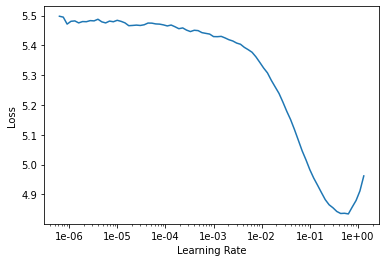

In [0]:
learn.recorder.plot(skip_end=10)

Figure: projection of how the model will perform based on different learning rates.

We can see that around 5e-01 the training starts to go south (i.e., the loss/error starts rocketing). The minimal loss is around 1e-1. Nevertheless, we have to choose a value that is approximately in the middle of the sharpest downward slope.

The main reason is:

> [...] the minimum value is already a bit too high, since we are at the edge between improving and getting all over the place. We want to go one order of magnitude before, a value that's still aggressive (so that we train quickly) but still on the safe side from an explosion.


This is given as an indication by the LR Finder tool, so let's try 2e-2.



In [0]:
learn.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.139524,3.206456,0.429861,24.691441,00:06
1,3.320149,2.970652,0.464683,19.504629,00:05
2,2.845574,2.905909,0.474851,18.281847,00:06
3,2.541204,2.895627,0.477852,18.094843,00:06


After just only a handful of epochs we have a pretty good result (i.e., remember that we are still fine-tuning the language model, so guessing right about half of times which is going to be the next word is a pretty good model). It seems that the default values of the library based on the super-convergence approach are just fine. In a more developed solution, we could spend some time trying to optimize them.

At this point it is important to explain what are we actually training. As I explained before, we have a pre-trained model of the English language. By pretrained, we mean nothing more the Neural Net has a set of weights already learned.
This model is quite deep, it has many number of layers with millions of parameters (a.k.a. weights) to learn. It has been posible to train such a huge model, because the entire Wikipedia was used. 

However, we only have a small bunch of tweets to adapt/fine-tune the model to our domain. Fine-tuning is nothing more than modifying a little bit the weights of the model, so they reflect the particular relationships in our data. But, since our dataset is rather small, if we try to retrain all the layers in the model, we will completely destroy it (the model will catastrophically forget everything learned from Wikipedia). 

It makes sense that the deeper layers in the model are actually learning the basic aspects of the language, while shallow layers are in charge of more high-level relationships. We do not want to change the deeper layers. Basic language relationships are basically the same in our dataset than in the entire English language (e.g., verb tenses, subject-object relationships). What we actually want to modify is the last layers of the model in charge of learning the high level relationships (e.g. Some disaster is happening somewhere). Well, that's exactly what the default training method in fast.ai is doing: It freezes the deeper layers so you do not modify them while you are fine-tuning your model. 

In the previous step, we have fine-tuned the LM to the particular content of our dataset. To do this, we just trained the last layers in our model to avoid forgetting everything. Now that our model is in a *stable* state (it has learned from our data without losing what learned from Wikipedia), we can further train our model by unfreeze all the layers.

The rationale is the following: we can slightly change the weights of all the layers so even the most basic aspects of the language can be redefined according to our data (e.g. Napoleonic wars Wikipedia pages can learn the model that France<-->invade is a likely outcome; however, I do not expect to read anything about a French invasion in the Twitter nowadays). 

It has been experimentally proven that this process can improve the performane of Deep Learning models (see this [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf) for more details). We have to be extremely careful with this process, otherwise we will ruin all our work. To that end, I have reduced my learning rate by an order of magnitude.



In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.409755,2.860762,0.485045,17.474840,00:06
1,2.166371,2.855345,0.492485,17.380424,00:06


As shown above, with only 2 epochs, the model has been improved already.


To understand what our language model is learning, you can run the [`Learner.predict`](https://docs.fast.ai/basic_train.html#Learner.predict) method and specify the number of words you want it to guess.

In [0]:
for _ in range(5):
  print(learn.predict("Haha South Tampa", n_words=25))

Haha South Tampa Being Burned ( ? ) in drought - Pakistan - India http : / / t.co / why # Myanmar
Haha South Tampa Some Gang Who Try to Riot : The Murderous Story Of americaûªs First Hijacking
Haha South Tampa her meltdown during Da Apocalypse # soundcloud ? http : / / t.co / EDM xxbos tired now my example is exploded
Haha South Tampa to dance lungs ? xxbos drive yours 
  Buses are always linked to the lives of rioting fans or fans . xxbos Multiple
Haha South Tampa ! ? 
 
  http : / / t.co / 06 Pandemonium xxbos People are finally in the middle of our population in #


It doesn't make much sense (we have a tiny vocabulary here and didn't train much on it) but note that it respects basic grammar (which comes from the pretrained model) while it has adapted the conversation to the content of the dataset.



I could futher train or experiment with more hyperparameters, but since the language model is not the final outcome and the LM seems good enough, I will move on to the classification step.


We can save the model for later uses. We need to save the encoder (the part that given a textual content creates the representation) which is the only part of the model needed for classification in the next section (i.e., the other part is the decoder in charge of translating the textual representation back to the text again).

In [0]:
learn.save_encoder('/content/drive/My Drive/nlp_disaster/models/ft_enc_extended')

### Building a classifier

It's now time to actually create the classifier taking our fine-tuned encoder. For this step we need the `data_clas` object we created earlier.

For this step, I will use again the default values in fast.ai to create a classification model. In this case, I will use the `text_classifier_learner`. We need to also tell the classifier that we want to use the fine-tuned encoder that we have just learned.

In [0]:
learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.8, metrics=[accuracy,FBeta(beta=1)])
learn_class.load_encoder('/content/drive/My Drive/nlp_disaster/models/ft_enc_extended')
learn_class.freeze()

I will plot again the learning rate to understand which one makes sense for the classification task.

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


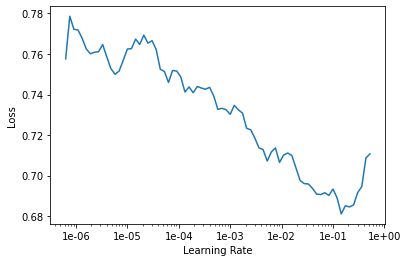

In [0]:
learn_class.lr_find()
learn_class.recorder.plot(skip_end=10)

Thanks to fast.ai super-convergence strategies, I think that just a small number of epochs should be enough. Let's see:

In [0]:
learn_class.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.587017,0.458607,0.790000,0.731261,00:07
1,0.559021,0.456950,0.793571,0.739405,00:07
2,0.541131,0.449950,0.801429,0.749098,00:07


In [0]:
learn_class.save('/content/drive/My Drive/nlp_disaster/models/1')


Great! 80% of accuracy.

As in the language modeling training, we have just trained the last layers of the model, we can gradually unfreeze the rest of the model and train it together.

In this case I will not unfreeze all the model at a time, but in different steps. This gradual unfreezing has been experimentally proven to improve the training process (again, check Howard and Ruder's paper).

In [0]:
learn_class.freeze_to(-2)
learn_class.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.532755,0.449707,0.796429,0.733396,00:07
1,0.525082,0.440217,0.806429,0.761653,00:07
2,0.494378,0.434785,0.807857,0.762157,00:08


In [0]:
learn.save('/content/drive/My Drive/clarity/models/2nd')


In [0]:
learn_class.freeze_to(-3)
learn_class.fit_one_cycle(3, slice(1e-3/2/(2.6**4),1e-3/3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.490811,0.436761,0.811429,0.762162,00:08
1,0.481934,0.436474,0.810714,0.758432,00:08
2,0.483669,0.435457,0.807857,0.752530,00:08


In [0]:
learn_class.save('/content/drive/My Drive/clarity/models/3rd')


In [0]:
learn_class.unfreeze()
learn_class.fit_one_cycle(10, slice(1e-3/10/(2.6**4),1e-3/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.467295,0.437380,0.810714,0.753488,00:08
1,0.471852,0.433497,0.811429,0.764286,00:08
2,0.485653,0.436482,0.807143,0.746241,00:08
3,0.470964,0.431472,0.814286,0.774306,00:08
4,0.466982,0.432327,0.808571,0.755475,00:08
5,0.466522,0.431400,0.815714,0.771277,00:07
6,0.456885,0.435905,0.807143,0.772727,00:08
7,0.460334,0.430711,0.814286,0.767857,00:08
8,0.462109,0.435370,0.806429,0.748375,00:08
9,0.437699,0.431185,0.812857,0.766488,00:08


In [0]:
learn_class.save('/content/drive/My Drive/clarity/models/classifier_5')


As can be seen in the results, our model is now offering accuracies up to 81%.

Again, we can predict on a raw text (the category in this case) by using the [`Learner.predict`](https://docs.fast.ai/basic_train.html#Learner.predict) method.

In [0]:
learn_class.predict("VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterran... http://t.co/ciwwUQthin")

(Category 1, tensor(1), tensor([0.0674, 0.9326]))

The predicted category is 1 (Disaster Tweet) and the model is 93% sure about it

In order to have a full report of this model performance, I will ask the model to offer me all the predictions and inspect the confusion matrix and the classification report

In [0]:
# get predictions
preds, targets = learn_class.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,708,169
1,93,430


In [0]:
from sklearn.metrics import classification_report

print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       801
           1       0.82      0.72      0.77       599

    accuracy                           0.81      1400
   macro avg       0.81      0.80      0.81      1400
weighted avg       0.81      0.81      0.81      1400



As can be seen in both the confusion matrix and in the classification report, the model is better not only in terms of accuracy, but also in its performance for all the classes when compared to the non Deep Learning models.

Finally, saving the model object to reuse it.

In [0]:
learn_class.save('/content/drive/My Drive/clarity/models/final_class_model')

Finally, lets create the submission file

In [0]:
preds, y, losses = learn_class.get_preds(ds_type=DatasetType.Test, with_loss=True)
y = torch.argmax(preds, dim=1)
submission = pd.DataFrame({'id': test_df.index, 'target': y})
submission.to_csv('submission_fastai.csv', index=False)

The final accuracy in Kaggle is 0.81